# Designing HybSeq Probes from a large sequence alignment


One of the most important considerations when designing probes for targeted sequencing is how related the the source sequences are to the potential samples that will be enriched. In phylogenetic studies of non-model organisms, there may not be prior sequences available in the target taxa, but minimizing sequence divergence is still important.

One solution is to use any existing sequence data to design probes from multiple ortholgous sources per gene. This effectively increases probe tiling and should also broaden the use of the probe set to more divergent taxa. Given a sequence alignment, we can choose sequences that are representative of specific clades, but this may be biased. 

Instead, we can let the data tell us what the most representative sequences should be. In this notebook we will generate pairwise distance matrices from DNA sequence alignments. The distances will be clustered using one or more multivariate statistics techniques (such as k-means clustering or discrimant analysis) to explore the optimal number of clusters for the alignment, and we will select representative sequences from each cluster.

We will use Python implementations of distance matrices and visualizations taken from the Introduction to Applied Bioinformatics: http://readiab.org/book/latest/2/3


In [1]:
%matplotlib inline
from skbio import TabularMSA, DNA, DistanceMatrix
from skbio.sequence.distance import hamming, kmer_distance
import pandas as pd
import matplotlib.pyplot as plt

gene = "6130"
fasta_filename = "/Users/mjohnson/Desktop/Projects/AngiospermHybSeq/genes/{}/FNA2AA-upp-masked.fasta".format(gene)
angiosperm_id_fn = "/Users/mjohnson/Desktop/Projects/AngiospermHybSeq/1kp_angio_codes.txt"
angio_1kp_ids = set([x.rstrip() for x in open(angiosperm_id_fn)])


## Reading the data

The MSA has a multiple sequence alignemnt of one gene from 1KP. We keep only the sequences from Angiosperms, including genome sequence.


In [2]:
msa = TabularMSA.read(fasta_filename, constructor=DNA)
seqs_to_keep = []
for seq in msa:
    if seq.metadata["id"] in angio_1kp_ids:
        seqs_to_keep.append(seq)
        
angio_msa = TabularMSA(seqs_to_keep)        
angio_msa.reassign_index(minter="id")
angio_msa.shape

Shape(sequence=670, position=3315)

Now that the alignment contains only angiosperms, remove the positions that are more than 95% gaps:

In [3]:
angio_msa_dict = angio_msa.to_dict()
angio_msa_df = pd.DataFrame(angio_msa_dict)

#This might throw an error if there are ever any positions without gaps. Seems unlikely for this dataset...

def gap_dectector(sequence_column):
    '''Returns the number of gap characters in a column of a sequence matrix'''
    try:
        return sequence_column.value_counts()[b"-"]
    except KeyError:
        return 0

gapped_columns = angio_msa_df.apply(gap_dectector ,axis=1)
#This could be modified to remove columns that have 90% gaps, etc.
angio_msa_df_nogaps = angio_msa_df[gapped_columns < len(angio_msa_df.columns) * 0.95]

#In skbio, DNA sequences are stored as bytecode, (b'A') so need to convert back to strings

nogap_seqs = [DNA(angio_msa_df_nogaps[i].str.decode("utf-8").str.cat(), metadata = {"id":i}) for i in angio_msa_df_nogaps]
angio_msa_nogap = TabularMSA(nogap_seqs)
#angio_msa_nogap.write("/Users/mjohnson/Desktop/Projects/AngiospermHybSeq/{}.onlyangios.fasta".format(gene))

angio_msa_nogap.shape


Shape(sequence=670, position=864)

We also want to remove the sequences that have > 50% gaps

In [4]:
seqs_to_keep = []
for seq in angio_msa_nogap:
    num_gaps = len([x for x in seq.gaps() if x])
    if num_gaps < angio_msa_nogap.shape[1] * 0.5:
        seqs_to_keep.append(seq)
        
angio_msa_nogap_noshort = TabularMSA(seqs_to_keep)
angio_msa_nogap_noshort.reassign_index(minter="id")

angio_msa_nogap_noshort.write("/Users/mjohnson/Desktop/Projects/AngiospermHybSeq/onekp_only_angios_degapped/{}.onlyangios.noshort.fasta".format(gene))
angio_msa_nogap_noshort.shape
        

Shape(sequence=649, position=864)

## Distance Matrix

We calculate the "Hamming distance" as described here: http://readiab.org/book/latest/2/4#6.3

The Hamming distance between two equal-length sequences is the proportion of differing characters.

We make a small adjustment to only calculate the Hamming distance between sites with no gaps (equivalent to the p-distance calculated by PAUP\*)


In [5]:
def p_distance(seq1,seq2):
    from skbio.sequence import Sequence
    from numpy import isnan
    myseq1 = str(seq1)
    myseq2 = str(seq2)
    
    degapped1 = []
    degapped2 = []
    
    for i in range(len(myseq1)):
        if myseq1[i] != "-":
            if myseq2[i] != "-":
                degapped1.append(myseq1[i])
                degapped2.append(myseq2[i])
    degapped1 = "".join(degapped1)
    degapped2 = "".join(degapped2)
    
    #print(degapped1)
    #print(degapped2)
    
    hamming_dist = hamming(Sequence(degapped1),Sequence(degapped2))
    #print(hamming_dist)
    if isnan(hamming_dist):
        #print(seq1.metadata["id"], seq2.metadata["id"])
        return 0.0
    else:
        return hamming_dist


p_dm = DistanceMatrix.from_iterable(angio_msa_nogap_noshort, metric=hamming, key='id')
print("Distance between Amborella and Rice:")
p_dm["Ambtr_v1.0.27","Orysa_v7.0"]

Distance between Amborella and Rice:


0.3611111111111111

The square pairwise distance matrix is shown below.

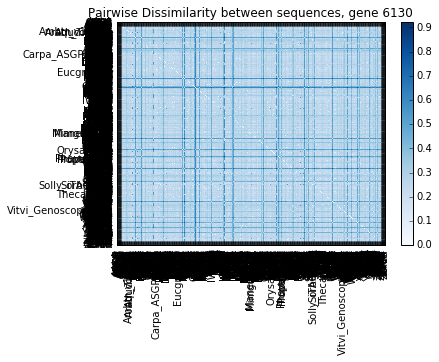

In [6]:
_ = p_dm.plot(cmap='Blues', title='Pairwise Dissimilarity between sequences, gene {}'.format(gene))
p_dm_df = p_dm.to_data_frame()
p_dm_df.to_csv("/Users/mjohnson/Desktop/Projects/AngiospermHybSeq/onekp_only_angios_pdistance/{}_angio_p_dm.csv".format(gene))

## Finding Representative Sequences -- Manual Selection

Now that we have a distance matrix, the next step is to decide which "representative" sequences are best for designing target capture probes. From the figure above we can see that some sequences diverged up to 80%, which is well beyond the tolerated range of 15-25%.

One solution is to manually choose sequences. For instance, we could choose only genomic sequences that we "know" to be relatively diverged from one another, and hope that they represent the spectrum of divergences for this gene. Let's try this by choosing: *Arabidopsis*, *Amborella*, *Oryza*, *Vitis*, *Mimulus*, and *Populus*.





Number of Distances > 30%: 72


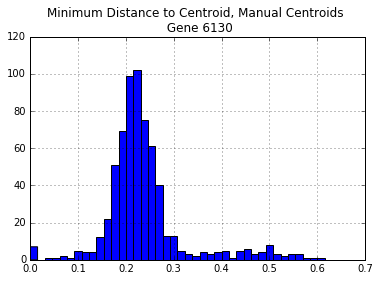

In [7]:
manual_centroids = ["Arath_TAIR10","Ambtr_v1.0.27","Orysa_v7.0","Vitvi_Genoscope.12X","Mimgu_v2.0","Poptr_v3.0"]
manual_centroid_dist = p_dm_df[manual_centroids].apply(min,1)
manual_centroid_dist.hist(bins=40)
plt.title("Minimum Distance to Centroid, Manual Centroids \n Gene {}".format(gene))
print("Number of Distances > 30%: {}".format(len(manual_centroid_dist[manual_centroid_dist > 0.3])))


There are too many sequences that are diverged more than 25% from each of our manually chosen sequences. The same is true even if we select all of the genome sequences:

Centroids:  ['Ambtr_v1.0.27', 'Aquco_v1.1', 'Arath_TAIR10', 'Carpa_ASGPBv0.4', 'Eucgr_v1.1', 'Manes_v4.1', 'Mimgu_v2.0', 'Orysa_v7.0', 'Phavu_v1.0', 'Poptr_v3.0', 'Prupe_v1.0', 'Solly_iTAGv2.3', 'Sorbi_v2.1', 'Theca_v1.1', 'Vitvi_Genoscope.12X']

Number of Distances > 30%: 63


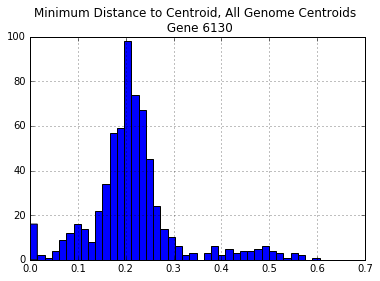

In [8]:
all_genomes = [x for x in p_dm_df.index if len(x) > 4]
all_genomes_centroid_dist = p_dm_df[all_genomes].apply(min,1)
all_genomes_centroid_dist.hist(bins=40)
print("Centroids: ",all_genomes)
plt.title("Minimum Distance to Centroid, All Genome Centroids \n Gene {}".format(gene))
print("\nNumber of Distances > 30%: {}".format(len(all_genomes_centroid_dist[all_genomes_centroid_dist > 0.3])))



## K-means clustering 

Instead, we could let the distances themselves tell us which sequences are best, by clustering the sequences by their pairwise dissimilarity. By pre-selecting a number of clusters, we can let the data tell us which sequences cluster together, and then choose a representative from each cluster.

Based on example from: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#example-cluster-plot-kmeans-digits-py

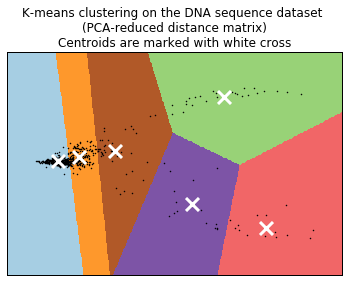

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

n_digits = 6 #number of clusters
pca = PCA().fit(p_dm_df)

reduced_data = PCA(n_components=2).fit_transform(p_dm_df)

kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, m_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the DNA sequence dataset \n(PCA-reduced distance matrix)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

The figure plots the PCA transformation of the distance matrix-- the axes correspond to PCA1 and PCA2, and each point represents a sequence in the alignment.

The polygons are drawn to estimate the cluster boundaries in two dimensions.

The white X represents the "centroid" of each cluster.

## Finding representative sequences -- cluster centroids

Now that we have predicted clusters, are these clusters sufficient to have all sequences within the cluster be no more than 30% divergent?

For each cluster, we figure out which of the real sequences in each cluster is closest to the centroid (Euclidean distance). Then we figure out the maximum pairwise distance any sequence and the centroid sequences. 


Centroids:  ['ODDO', 'LDME', 'QTJY', 'XKPS', 'XVRU', 'RMVB']

Number of Distances > 30%: 31


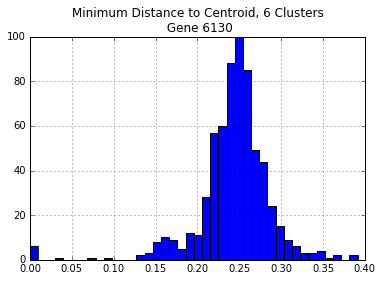

In [10]:
#Group the distance matrix by kmeans clusters
from scipy.spatial import distance

grouped = p_dm_df.groupby(kmeans.labels_)
centroids = []
for name,group in grouped:
    #print("Group number: {}".format(name))
    
    #Find the sample that is closest to the centroid. This is a pd Dataframe row index.
    closest_to_centroid = pd.DataFrame(reduced_data).groupby(kmeans.labels_).get_group(name).apply(
        lambda x: distance.euclidean(x,kmeans.cluster_centers_[name]), axis=1).sort_values().index[0]
    #print("Number of sequences in group: {}".format(len(group)))
    
    #Reduce the distance matrix to be square within the group
#    reduced_group = group[group.index]
#    print("Max distance within group: {}".format(max(reduced_group.apply(max))))
    closest_id = p_dm_df.index[closest_to_centroid]
    #print("ID closest to centroid (Euclidean): {}".format(closest_id))
    centroids.append(closest_id)
    
#    print("Furthest within-group P distance distances to centroids ID:")
#    print(reduced_group[closest_id].sort_values(ascending=False)[0:2])
#    print()
#centroids.append("Arath_TAIR10")
print("Centroids: ", centroids)
centroid_dist = p_dm_df[centroids].apply(min,1)
centroid_dist.hist(bins=40)
plt.title("Minimum Distance to Centroid, {} Clusters\n Gene {}".format(n_digits,gene))
print("\nNumber of Distances > 30%: {}".format(len(centroid_dist[centroid_dist > 0.30])))


Before, using sequences from all of the genomes left almost twice as many sequences with > 30% divergence. Ideally, we could pick the number of clusters that minimizes the number of sequences with > 30% divergence.

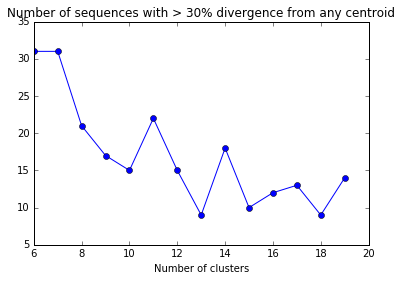

In [11]:
divergent_seqs = []
for i in range(6,20):
    n_digits = i #number of clusters
    pca = PCA().fit(p_dm_df)

    reduced_data = PCA(n_components=2).fit_transform(p_dm_df)

    kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
    kmeans.fit(reduced_data)
    grouped = p_dm_df.groupby(kmeans.labels_)
    centroids = []
    for name,group in grouped:    
        #Find the sample that is closest to the centroid. This is a pd Dataframe row index.
        closest_to_centroid = pd.DataFrame(reduced_data).groupby(kmeans.labels_).get_group(name).apply(
            lambda x: distance.euclidean(x,kmeans.cluster_centers_[name]), axis=1).sort_values().index[0]
        closest_id = p_dm_df.index[closest_to_centroid]
        centroids.append(closest_id)
    #print("Centroids: ", centroids)
    centroid_dist = p_dm_df[centroids].apply(min,1)
    num_over_25 = len(centroid_dist[centroid_dist > 0.30])
    divergent_seqs.append((i,num_over_25))
    
    #centroid_dist.hist(bins=40)
    #plt.title("Minimum Distance to Centroid, {} Clusters\n Gene {}".format(n_digits,gene))
    #print("\n\n Distances > 25%:")
    #print("\nNumber of Distances > 25%: {}".format(len(centroid_dist[centroid_dist > 0.25])))

divergent_seqs_df = pd.DataFrame(divergent_seqs,columns=["NumClusters","NumDivergent"])
plt.plot(divergent_seqs_df.NumClusters,divergent_seqs_df.NumDivergent,'-o')
plt.xlabel("Number of clusters")
plt.title("Number of sequences with > 30% divergence from any centroid")


The number of sequences with > 30% divergence may fluctuate as the number of clusters is increased because the clusters (and centroids) may be chosen differently if the kmeans fit is repeated. In this case, choosing 13 or more clusters will have the best effect.

## Spectral Clustering

Another option for assigning sequences to clusters is spectral clustering.

/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:629: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


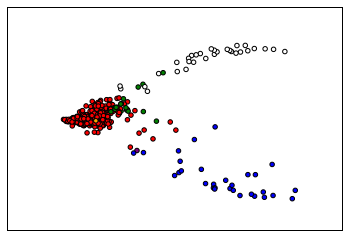

In [12]:
import numpy as np
import scipy as sp
from sklearn.cluster import spectral_clustering

similarity = np.exp(-2 * p_dm_df / p_dm_df.std()).as_matrix()

labels = spectral_clustering(similarity,n_clusters=6,assign_labels = 'discretize')
colormap = np.array(["r","g","b","w","purple","orange","brown","lightblue"])
plt.scatter(reduced_data[:, 0], reduced_data[:, 1],c=colormap[labels])
plt.xticks(())
plt.yticks(())
plt.show()

The assignment of sequences to clusters is less important than reliably definining a "representative," so we may need to explore alternative ways of "reducing" the distance data besides PCA.